This module is meant to run a bunch of tests on AMR waves on some arbitrary AMR grid. I recommend comparing the results in cell 13 between even and odd numbers for `refCells`.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
from fractions import Fraction


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

This cell is for all the input variables. `nh` is the number of coarse cells; `refCells` is the number of coarse cells on which you want to refine.

In [2]:
nh = 16
refRatio = 2
refCells = 4
Hans = True
prenorm = False

In [3]:
# ----------------------------------------------------------------------------------------------------------------
# Function: Normalization
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner product of an input matrix with itself, outputs that inner product matrix, and
# then prints to screen a bunch of tests on that inner product matrix. The first test is for symmetry; if WTW is
# symmetric, then this should be a matrix of zeros. The next is the inverse. The next is the symmetry of the
# inverse. The next two are WTW left- and right-multiplied by its inverse. The last three are the determinant,
# eigenvalues, and eigenvectors of WTW. If WTW contains an eigenvalue of zero, the eigenvector corresponding to
# that eigenvalue is also output to screen; this consitutes the nullspace of WTW.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------
# Output:
#
# WTWinv              (M x M) real        A positive non negative number given by the user
# ----------------------------------------------------------------------------------------------------------------

In [4]:
def TestThings(WTW):
    det = LA.det(WTW)
    sym = WTW - WTW.transpose()
    WTWinv = LA.inv(WTW)
#     WWTW = waves @ WTWinv
    syminv = WTWinv - WTWinv.transpose()
    ID1 = WTWinv @ WTW
    ID2 = WTW @ WTWinv
    eigvals, eigvecs = LA.eig(WTW)
    eigvals = abs(np.round(eigvals, 12))
    condition = False
    if (any(eigvals == 0)):
        condition = True
        index = np.where(abs(np.round(eigvals, 12)) == 0)[0]
        zeroVec = eigvecs[:, index]
    
#     print('W(W^TW)^-1 =')
#     print(np.round(WWTW, 14))
    print('')
    print('symmetry of W^TW:')
    print(np.round(sym, 14))
    print('')
    print('(W^TW)^-1:')
    print(np.round(WTWinv, 14))
    print('')
    print('symmetry of (W^TW)^-1:')
    print(np.round(syminv, 14))
    print('')
    print('identity 1:')
    print(np.round(ID1, 14))
    print('')
    print('identity 2:')
    print(np.round(ID2, 14))
    print('')
    print('determinant =', det)
    print('')
    print('eigenvalues:')
    print(np.round(eigvals, 14))
    print('')
    print('eigenvectors:')
    print(np.round(eigvecs, 12))
    if (condition):
        print('')
        print('nullspace of W^TW:')
        print(np.round(zeroVec, 12))
    print('')
    
    return WTWinv

In [5]:
def Normalization(waves):
    WTW = waves.transpose() @ waves
    print('')
    print('W^TW:')
    print(np.round(WTW, 14))
    WTWinv = TestThings(WTW)
    return WTWinv

In [6]:
# ----------------------------------------------------------------------------------------------------------------
# Function: DotEach
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner products of each pair of vectors in the input matrix and prints them to screen.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------

In [7]:
def DotEach(waves):
    iters = np.shape(waves)[1]
    print(np.round(waves, 14))
    print('')
    for k in range(iters):
        for j in range(k, iters):
            dotprod = np.round(waves[:, k].transpose() @ waves[:, j], 14)
            print(str(k) + ' dot ' + str(j) + ': ' + str(dotprod))
            print('')
    return

In [8]:
def Prenormalize(omega, waves):
    degFreed = omega.degFreed
    hs = omega.h
    nhs = omega.nh
    nh_max= omega.nh_max
    dim = np.shape(waves)
    newWaves = np.zeros(dim, float)
    print('waves:')
    print(waves)
    print('')
    for nh in nhs:
        alias = int(nh_max / nh)
        omegah = BT.Grid(nh, alias = alias)
        wavesh = WT.MakeWaves(omegah)
        norm = np.diag(np.diag(np.round(wavesh.transpose() @ wavesh, 14) ** -1))
        norm[norm == inf] = 0#np.round(LA.inv(prenorm), 14)
        print('nh:')
        print(nh)
        print('')
        h = 1. / nh
        stripLoc = np.where(hs == h)[0]
        antipiece = waves + 0
        antipiece[stripLoc, :] = 0
        piece = (waves - antipiece) @ norm
        print('antipiece:')
        print(antipiece)
        print('')
        print('piece:')
        print(piece)
        print('')
        print('norm:')
        print(norm)
        print('')
        newWaves = newWaves + piece
    waves = newWaves
    print('newWaves:')
    print(waves)
    print('')
    return

This cell instantiates the AMR and the fine grid and finds the AMR and fine waves as well as the nullspace.

In [9]:
finehalf = list(np.arange(refCells))
omega = BT.Grid(nh)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
degFreed = omega.degFreed
omegaF = BT.Grid(nh_max)

waves = WT.MakeWaves(omega)
wavesF = WT.MakeWaves(omegaF)
nullspace = OT.FindNullspace(omega, waves, Hans = Hans)
print(nullspace)
if (prenorm):
    Prenormalize(omega, waves)

wavesMod = waves @ nullspace
wavesFMod = wavesF @ nullspace
restrictOp = GTT.CoarsenOp(omega)



[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

This cell plots the waves in the nullspace.

[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0.04459942  0.54130631  0.44389062  0.48046375]
[ 0.02194388  0.          0.03185673 -0.0663382  -0.07637773 -0.14112764 -0.27179134 -0.05406266 -0.32613733  0.2496147  -0.04459942  0.54130631  0.44389062  0.48046375]

[ 0.09894596  0.10135007  0.29077708  0.00726783  0.30742193 -0.28359265  0.0297767  -0.49346507 -0.317697   -0.38077479 -0.40708791 -0.05930401 -0.2175482   0.11627851]
[ 0.09894596  0.10135007  0.29077708  0.00726783  0.30742193 -0.28359265  0.0297767  -0.49346507 -0.317697   -0.38077479 -0.40708791 -0.05930401 -0.2175482   0.11627851]

Gram-Schmidt:
[[ 0.02194388  0.09894596]
 [ 0.          0.10135007]
 [ 0.03185673  0.29077708]
 [-0.0663382   0.00726783]
 [-0.07637773  0.30742193]
 [-0.14112764 -0.28359265]
 [-0.27179134  0.0297767 ]
 [-0.05406266 -0.49346507]
 [-0.32613733 -0.317697  ]
 [ 0.2496147  -0.38077479]
 [-0.04459942 -0.40708791]
 [ 0.54

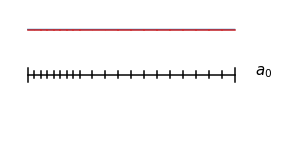

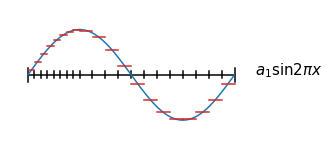

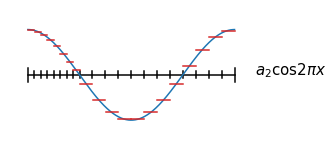

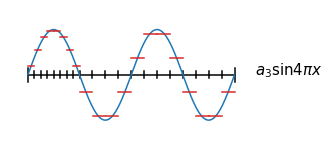

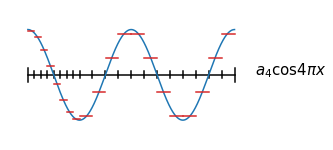

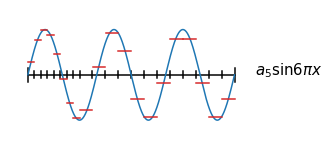

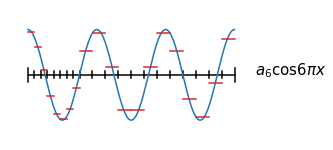

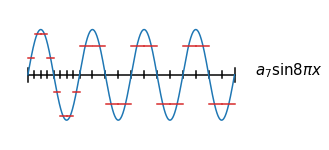

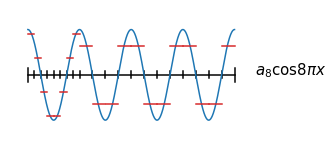

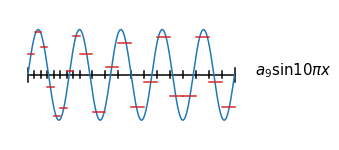

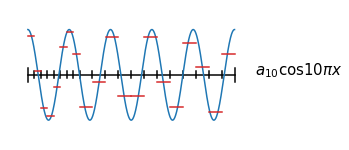

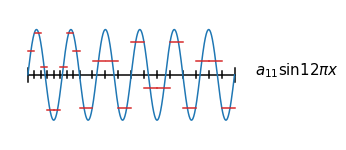

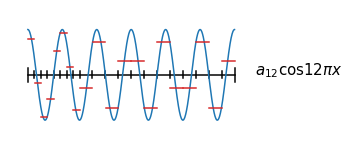

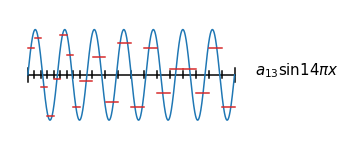

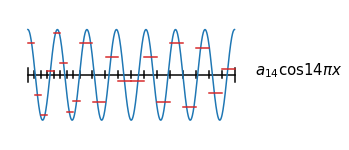

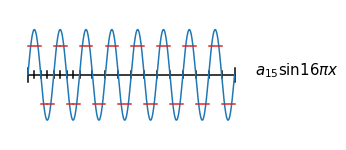

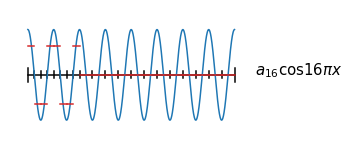

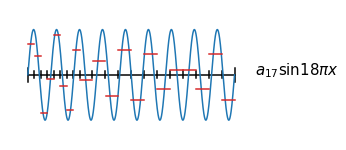

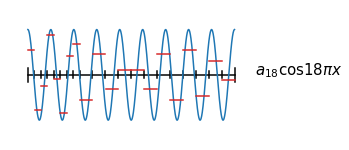

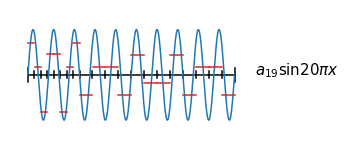

In [10]:
FCoefF = np.zeros(nh_max, float)
FCoefF[-1] = 1
waveformAMR = restrictOp @ wavesF @ FCoefF
FCoefAMR = FFTT.FourierCoefs(omega, wavesMod, waveformAMR)
print(FCoefAMR)
print(FCoefAMR)
PT.PlotWaves(omega, waves = waves, nullspace = nullspace)
# PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ FCoefAMR)
print('\n\n\n\n\n\n\n\n\n\n')
# PT.PlotWaves(omegaF, waves = wavesF)

In [11]:
# degFreed = omega.degFreed
# FCoefs1 = np.zeros(degFreed, float)
# FCoefs2 = FCoefs1 + 0
# FCoefs1[-2] = 1
# FCoefs2[-1] = 1
# FCoefs = FCoefs1 - FCoefs2
# allCoefs = PT.Load(FCoefs, FCoefs1, FCoefs2)
# labels = ['FCoefs', 'FCoefs1', 'FCoefs2']
# print(FCoefs)
# PT.PlotMixedWave(omega, waves = waves, waveCoef = nullspace @ allCoefs, labels = labels, rescale = 6, yGrid = True)


In [12]:
# w0 = waves[:, 0]
# w1 = waves[:, 1]
# print(w0.transpose() @ w1)
# hAMR = omega.h
# print(hAMR)
# print((hAMR.transpose() * w0) @ w1)
# mat = np.diag(hAMR)
# print(np.round(waves.transpose() @ mat @ waves, 14))


The results in this cell make sense to me.

In [13]:
print('Tests on AMR Waves without Nullspace Treatment:')
normWrong = Normalization(waves)


Tests on AMR Waves without Nullspace Treatment:

W^TW:
[[ 2.00000000e+01  2.54647909e+00  2.54647909e+00  2.54647909e+00 -0.00000000e+00  8.48826363e-01 -8.48826363e-01 -0.00000000e+00 -0.00000000e+00  5.09295818e-01  5.09295818e-01  8.48826363e-01 -0.00000000e+00  3.63782727e-01 -3.63782727e-01 -0.00000000e+00 -0.00000000e+00  2.82942121e-01  2.82942121e-01  5.09295818e-01 -0.00000000e+00  2.31498099e-01 -2.31498099e-01  0.00000000e+00 -0.00000000e+00  1.95883007e-01  1.95883007e-01  3.63782727e-01 -0.00000000e+00  1.69765273e-01 -1.69765273e-01  0.00000000e+00]
 [ 2.54647909e+00  9.91045444e+00  1.26483365e+00  1.70800950e+00 -8.70754725e-01 -0.00000000e+00 -1.29756494e+00 -6.82396040e-01 -1.88358685e-01  0.00000000e+00  4.07464253e-01  4.37585915e-01 -9.26439236e-02  0.00000000e+00 -4.45743884e-01 -3.22464584e-01 -6.35199788e-02 -0.00000000e+00  2.26809777e-01  2.53425993e-01 -5.51711679e-02  0.00000000e+00 -2.83294587e-01 -2.02659252e-01 -6.19224313e-02 -0.00000000e+00  9.90733420e

In [14]:
DotEach(waves)

[[ 1.          0.09785976  0.99358685  0.19383918  0.97449536  0.28610607  0.94316532  0.37292323  0.90031632  0.45269244  0.84692799  0.52399458  0.7842133   0.58562448  0.71358549  0.63661977  0.63661977  0.67628278  0.55501094  0.70419489  0.47052798  0.7202231   0.38496727  0.72451862  0.30010544  0.71750755  0.21765354  0.69987414  0.13921362  0.67253711  0.06623912  0.63661977]
 [ 1.          0.28981859  0.95540387  0.55200728  0.82613727  0.76188308  0.62526129  0.90031632  0.37292323  0.95569734  0.09412797  0.92504266 -0.18400243  0.81412381 -0.43515824  0.63661977 -0.63661977  0.41241033 -0.77156546  0.16522745 -0.83065451 -0.08004593 -0.81271998 -0.30010544 -0.72451862 -0.4756639  -0.57959814 -0.59332465 -0.39644686 -0.64669188 -0.19617184 -0.63661977]
 [ 1.          0.47063986  0.88050525  0.82613727  0.55200728  0.98085919  0.0966062   0.90031632 -0.37292323  0.60922154 -0.74233859  0.18400243 -0.92504266 -0.26796912 -0.88337581 -0.63661977 -0.63661977 -0.83719731 -0.25396


16 dot 25: 0.54936402482558

16 dot 26: 0.54936402482558

16 dot 27: 0.96452773733119

16 dot 28: 0.0

16 dot 29: 0.43653838212964

16 dot 30: -0.43653838212964

16 dot 31: 0.0

17 dot 17: 4.90980498061384

17 dot 18: 0.79266517795856

17 dot 19: 1.86628656580705

17 dot 20: -1.24411358000719

17 dot 21: 0.0

17 dot 22: -1.55194857016421

17 dot 23: -0.76048680454319

17 dot 24: -0.271354596451

17 dot 25: 0.0

17 dot 26: 0.45984128866321

17 dot 27: 0.52945382292014

17 dot 28: -0.08625764223158

17 dot 29: 0.0

17 dot 30: -0.51219554813858

17 dot 31: -0.43896966927977

18 dot 18: 4.90980498061384

18 dot 19: 1.86628656580704

18 dot 20: 1.24411358000719

18 dot 21: 1.55194857016422

18 dot 22: 0.0

18 dot 23: 0.76048680454319

18 dot 24: -0.271354596451

18 dot 25: 0.45984128866321

18 dot 26: 0.0

18 dot 27: 0.52945382292014

18 dot 28: 0.08625764223159

18 dot 29: 0.51219554813858

18 dot 30: 0.0

18 dot 31: 0.43896966927977

19 dot 19: 4.19752758983705

19 dot 20: 0.0

19 dot 21

The results in this cell do not.

In [15]:
print('AMR Waves with Nullspace Treatment:')
print('')
print('W:')
print(wavesMod)
normAMR = Normalization(wavesMod)

# LOOK AT WHAT HAPPENS TO THE CONSTANT MODE WHEN YOU SWITCH BETWEEN THE EVEN AND ODD CASES.
print('LOOK HERE:')
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normAMR)
print('')
FCoefs = np.round(nullspace @ (waves.transpose() @ wavesMod @ normAMR).transpose(), 13)
print(FCoefs)
print('')
print(FCoefs[1, 13] ** 2)
print(Fraction(FCoefs[1, 13] ** 2))


AMR Waves with Nullspace Treatment:

W:
[[ 1.00000000e+00  9.78597633e-02  9.93586851e-01  1.93839179e-01  9.74495358e-01  2.86106072e-01  9.43165321e-01  3.72923229e-01  9.00316316e-01  4.52692443e-01  8.46927993e-01  5.23994577e-01  7.84213304e-01  5.85624475e-01  7.13585488e-01  6.36619772e-01  6.36619772e-01  6.76282781e-01  5.55010935e-01  7.04194890e-01]
 [ 1.00000000e+00  2.89818594e-01  9.55403866e-01  5.52007278e-01  8.26137274e-01  7.61883082e-01  6.25261286e-01  9.00316316e-01  3.72923229e-01  9.55697336e-01  9.41279718e-02  9.25042664e-01 -1.84002426e-01  8.14123810e-01 -4.35158243e-01  6.36619772e-01 -6.36619772e-01  4.12410330e-01 -7.71565459e-01  1.65227455e-01]
 [ 1.00000000e+00  4.70639859e-01  8.80505245e-01  8.26137274e-01  5.52007278e-01  9.80859189e-01  9.66061981e-02  9.00316316e-01 -3.72923229e-01  6.09221540e-01 -7.42338594e-01  1.84002426e-01 -9.25042664e-01 -2.67969123e-01 -8.83375811e-01 -6.36619772e-01 -6.36619772e-01 -8.37197309e-01 -2.53961027e-01 -8.30654

In [16]:
DotEach(wavesMod)

[[ 1.          0.09785976  0.99358685  0.19383918  0.97449536  0.28610607  0.94316532  0.37292323  0.90031632  0.45269244  0.84692799  0.52399458  0.7842133   0.58562448  0.71358549  0.63661977  0.63661977  0.67628278  0.55501094  0.70419489]
 [ 1.          0.28981859  0.95540387  0.55200728  0.82613727  0.76188308  0.62526129  0.90031632  0.37292323  0.95569734  0.09412797  0.92504266 -0.18400243  0.81412381 -0.43515824  0.63661977 -0.63661977  0.41241033 -0.77156546  0.16522745]
 [ 1.          0.47063986  0.88050525  0.82613727  0.55200728  0.98085919  0.0966062   0.90031632 -0.37292323  0.60922154 -0.74233859  0.18400243 -0.92504266 -0.26796912 -0.88337581 -0.63661977 -0.63661977 -0.83719731 -0.25396103 -0.83065451]
 [ 1.          0.6333747   0.7717693   0.97449536  0.19383918  0.86922614 -0.46461105  0.37292323 -0.90031632 -0.27876663 -0.91897042 -0.7842133  -0.52399458 -0.91868018  0.0904821  -0.63661977  0.63661977 -0.08575214  0.87065614  0.47052798]
 [ 1.          0.7717693   0

This is what I believed you asked of me.

In [17]:
print('Fine Waves with Nullspace Treatment:')
normF = Normalization(wavesFMod)
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normF)
print((wavesMod @ normF)[:, 0])

Fine Waves with Nullspace Treatment:

W^TW:
[[ 3.20000000e+01 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00  1.59486618e+01 -0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.00000000e-14 -0.00000000e+00  0.00000000e+00 -1.00000000e-14  1.00000000e-14 -0.00000000e+00 -0.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00  1.59486618e+01  0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  1.00000000e-14 -0.00000000e+00 -0.00000000e+00 -1.00000000e-14  1.00000000e-14 -1.0

In [18]:
DotEach(wavesFMod)

[[ 1.          0.09785976  0.99358685  0.19383918  0.97449536  0.28610607  0.94316532  0.37292323  0.90031632  0.45269244  0.84692799  0.52399458  0.7842133   0.58562448  0.71358549  0.63661977  0.63661977  0.67628278  0.55501094  0.70419489]
 [ 1.          0.28981859  0.95540387  0.55200728  0.82613727  0.76188308  0.62526129  0.90031632  0.37292323  0.95569734  0.09412797  0.92504266 -0.18400243  0.81412381 -0.43515824  0.63661977 -0.63661977  0.41241033 -0.77156546  0.16522745]
 [ 1.          0.47063986  0.88050525  0.82613727  0.55200728  0.98085919  0.0966062   0.90031632 -0.37292323  0.60922154 -0.74233859  0.18400243 -0.92504266 -0.26796912 -0.88337581 -0.63661977 -0.63661977 -0.83719731 -0.25396103 -0.83065451]
 [ 1.          0.6333747   0.7717693   0.97449536  0.19383918  0.86922614 -0.46461105  0.37292323 -0.90031632 -0.27876663 -0.91897042 -0.7842133  -0.52399458 -0.91868018  0.0904821  -0.63661977  0.63661977 -0.08575214  0.87065614  0.47052798]
 [ 1.          0.7717693   0


6 dot 12: 0.0

6 dot 13: 0.0

6 dot 14: -0.0

6 dot 15: 0.0

6 dot 16: 0.0

6 dot 17: 0.0

6 dot 18: 1e-14

6 dot 19: 0.0

7 dot 7: 15.19425925682853

7 dot 8: -0.0

7 dot 9: 0.0

7 dot 10: -0.0

7 dot 11: -0.0

7 dot 12: -0.0

7 dot 13: -0.0

7 dot 14: -1e-14

7 dot 15: 1e-14

7 dot 16: -0.0

7 dot 17: 0.0

7 dot 18: 1e-14

7 dot 19: -0.0

8 dot 8: 15.19425925682855

8 dot 9: -0.0

8 dot 10: -0.0

8 dot 11: -0.0

8 dot 12: -0.0

8 dot 13: 0.0

8 dot 14: 0.0

8 dot 15: -0.0

8 dot 16: -1e-14

8 dot 17: -0.0

8 dot 18: -0.0

8 dot 19: 0.0

9 dot 9: 14.75547956390863

9 dot 10: -0.0

9 dot 11: 0.0

9 dot 12: -0.0

9 dot 13: 0.0

9 dot 14: -0.0

9 dot 15: -0.0

9 dot 16: 1e-14

9 dot 17: -0.0

9 dot 18: 0.0

9 dot 19: 0.0

10 dot 10: 14.75547956390864

10 dot 11: 0.0

10 dot 12: -0.0

10 dot 13: -0.0

10 dot 14: 0.0

10 dot 15: -1e-14

10 dot 16: -0.0

10 dot 17: -0.0

10 dot 18: -0.0

10 dot 19: 0.0

11 dot 11: 14.23297315607765

11 dot 12: -0.0

11 dot 13: -0.0

11 dot 14: -0.0

11 dot

In [19]:
# [[ 0.        ]
#  [ 0.07396956]
#  [ 0.0306392 ]
#  [ 0.1132277 ]
#  [ 0.1132277 ]
#  [ 0.09191759]
#  [ 0.22190869]
#  [ 0.        ]
#  [ 0.32025631]
#  [-0.32025631]
#  [-0.24912485]
#  [ 0.3754923 ]
#  [-0.33404366]
#  [ 0.3464999 ]
#  [-0.52002231]]

# [[ 0.        ]
#  [ 0.03688315]
#  [ 0.08904379]
#  [-0.02590328]
#  [ 0.02590328]
#  [ 0.16559858]
#  [ 0.06859318]
#  [ 0.        ]
#  [ 0.3683307 ]
#  [-0.51486176]
#  [-0.01920905]
#  [ 0.73770533]
#  [ 0.10914531]]

# [[ 0.        ]
#  [-0.02486985]
#  [ 0.06004112]
#  [ 0.07034254]
#  [ 0.07034254]
#  [ 0.07460954]
#  [-0.03090428]
#  [ 0.        ]
#  [ 0.45891091]
#  [-0.67426232]
#  [-0.56047288]]


# [[ 0.        ]
#  [-0.01372416]
#  [ 0.00917019]
#  [-0.0119001 ]
#  [ 0.02872937]
#  [ 0.00818972]
#  [ 0.04117248]
#  [ 0.03365856]
#  [ 0.03365856]
#  [ 0.04585096]
#  [ 0.00912032]
#  [ 0.03570029]
#  [-0.01478754]
#  [ 0.01276845]
#  [-0.01910934]
#  [ 0.        ]
#  [ 0.45269843]
#  [-0.77963153]
#  [-0.42162122]]

In [20]:
# vec = np.round(wavesMod[:, -1], 14)
# print(vec)
# norm = vec.transpose() @ vec
# print(norm)
# print(vec / norm)
# print('')

In [21]:
print(wavesMod)
print('')
blah = TestThings(wavesMod)


[[ 1.00000000e+00  9.78597633e-02  9.93586851e-01  1.93839179e-01  9.74495358e-01  2.86106072e-01  9.43165321e-01  3.72923229e-01  9.00316316e-01  4.52692443e-01  8.46927993e-01  5.23994577e-01  7.84213304e-01  5.85624475e-01  7.13585488e-01  6.36619772e-01  6.36619772e-01  6.76282781e-01  5.55010935e-01  7.04194890e-01]
 [ 1.00000000e+00  2.89818594e-01  9.55403866e-01  5.52007278e-01  8.26137274e-01  7.61883082e-01  6.25261286e-01  9.00316316e-01  3.72923229e-01  9.55697336e-01  9.41279718e-02  9.25042664e-01 -1.84002426e-01  8.14123810e-01 -4.35158243e-01  6.36619772e-01 -6.36619772e-01  4.12410330e-01 -7.71565459e-01  1.65227455e-01]
 [ 1.00000000e+00  4.70639859e-01  8.80505245e-01  8.26137274e-01  5.52007278e-01  9.80859189e-01  9.66061981e-02  9.00316316e-01 -3.72923229e-01  6.09221540e-01 -7.42338594e-01  1.84002426e-01 -9.25042664e-01 -2.67969123e-01 -8.83375811e-01 -6.36619772e-01 -6.36619772e-01 -8.37197309e-01 -2.53961027e-01 -8.30654509e-01]
 [ 1.00000000e+00  6.33374698e-

 [ 0.00000000e+00  0.00000000e+00 -1.87500000e-01 -6.25000000e-02 -9.27734375e-03  9.37500000e-02 -2.50000000e-01  7.27539062e-02 -9.37500000e-02  9.37500000e-02  1.56250000e-02 -1.01562500e-01  1.22070312e-03 -1.81396484e-01 -3.56445312e-02 -1.22802734e-01 -1.56250000e-01  5.66406250e-02  1.68945312e-01  1.06103516e+00]]

identity 2:
[[ 1.00895724e+00 -2.97142142e-04  1.69550652e-02  1.97066603e-02  3.04455972e-02 -3.34089413e-02  1.21290634e-02 -2.93033076e-03  7.18383358e-04 -3.31898356e-04 -1.94898562e-04 -3.19476057e-05  5.81367345e-06  8.27040088e-05  1.88486571e-05  5.85391086e-05 -9.15527344e-05  2.13623047e-04 -3.66210938e-04 -1.34277344e-03]
 [ 1.32636810e-01  7.27596021e-01  4.28769938e-01 -7.00922941e-01  3.84694390e-01 -4.18528768e-01  4.05369488e-01 -5.21185238e-02  2.48342882e-02 -4.20615308e-03  2.32501019e-03 -1.50042419e-03  7.93725681e-04 -1.25811513e-03  4.54631830e-04 -8.04754443e-04  1.15966797e-03 -3.41796875e-03  2.19726562e-03 -1.11083984e-02]
 [-1.00501868e-01

In [22]:
[[-0.        ]
 [-0.02486985]
 [ 0.06004112]
 [ 0.07034254]
 [ 0.07034254]
 [ 0.07460954]
 [-0.03090428]
 [ 0.        ]
 [ 0.45891091]
 [-0.67426232]
 [-0.56047288]]

bluh = TestThings(wavesMod.transpose())

TypeError: list indices must be integers or slices, not float